In [1]:
from bs4 import BeautifulSoup
import requests
import pickle
import numpy as np
import re
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

# Film Success in China - Data Acquisition and EDA
Metis Project 2  
(File 1 of 2)  
October 12, 2020  
Amanda Cheney  


**Objective**  
Build a regression model to explain the success of films in the Chinese market. 

**Sources**  
Chinese box office data on over 1,000 films released in China in the years 2016-2019 scraped from [Box Office Mojo](https://www.boxofficemojo.com/weekend/by-year/2019/?area=CN) and supplemented by the [IMDb movies extensive](https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset?select=IMDb+movies.csv) dataset on Kaggle.

## Part 1: Obtain Data

Create several functions `weekend_getter`, `link_getter`, `dict_maker`, `imdb_code_getter` and `imdb_code_refiner` to scrape the data from Box Office Mojo.

In [2]:
def weekend_getter(years):
    """
    Scrapes the BoxOfficeMojo website for Chinese box office weekends of a given 
    year and returns a list of links for each weekend of that year.
    Input: List of years
    Output: List of urls for each weekend of the input years 
    """
    list_of_weekend_links = []
    for year in years:
        source_code = requests.get(f'https://www.boxofficemojo.com/weekend/by-year/{year}/?area=CN')
        soup = BeautifulSoup(source_code.text, 'html5lib')        
        list_of_weekends = soup.findAll('td', {'class': 'a-text-right mojo-field-type-date_interval'})
        for weekend in list_of_weekends:
            link = weekend.find("a")["href"]
            list_of_weekend_links.append(link)
        url = 'https://www.boxofficemojo.com/'
        weekend_urls = [url + link for link in list_of_weekend_links]
    return weekend_urls

In [3]:
def link_getter(weekend_urls):
    """
    Scrapes individual Chinese box office weekend Box Office Mojo webpages and 
    returns a list of movies for all the input weekends.
    Input: List of urls for box office weekends 
    Output: List of movies from all the input weekends 
    """
    list_of_movie_links = []
    for url in weekend_urls:
        source_code = requests.get(url)
        soup = BeautifulSoup(source_code.text, 'html5lib')
        list_of_movies = soup.findAll('td', {'class': 'a-text-left mojo-field-type-release mojo-cell-wide'})
        for movie in list_of_movies:
            link = movie.find("a")["href"]
            list_of_movie_links.append(link)
        url = 'https://www.boxofficemojo.com/'
        movie_urls = [url + link for link in list_of_movie_links] 
    return movie_urls

In [4]:
def dict_maker(movie_urls):
    """
    Scrapes the Box Office Mojo webpage of a given movie and extracts information 
    about that movie's revenue, runtime, genres, release period and release date.
    Input: A list of movie urls.
    Output: A tuple of five dictionaries - revenue at index 0, runtime [1], 
    genres [2], release period [3] and release date [5].
    
    """
    revenue_dict = {}
    runtime_dict={}
    genres_dict = {}
    release_period_dict = {}
    release_date_dict = {}
    for movie in movie_urls:
        source_code = requests.get(movie)
        soup = BeautifulSoup(source_code.text, 'html5lib')
        title = soup.find('h1').text
        list_grosses = soup.find(class_='a-section a-spacing-none mojo-performance-summary-table').find_all(class_='money')
        
        # revenue dict 
        list_of_rev = [item.text for item in list_grosses]
        if len(list_of_rev)< 3:
            list_of_rev.insert(1,np.NaN) 
        revenue_dict[title]=list_of_rev
        
        # running time dict 
        rt_string = soup.find(text=re.compile('Running Time'))
        if rt_string == None:
            runtime_dict[title]=np.NaN
        else:
            rt = rt_string.findNext().text
            rt = rt.split()
            if len(rt)==2:
                minutes = int(rt[0])*60
            else:
                minutes = int(rt[0])*60 + int(rt[2])
            runtime_dict[title]=minutes

        #genre dict
        genre_finder = soup.find(text=re.compile('Genres'))
        if genre_finder == None:
            genres_dict[title]=np.NaN
        else:
            genre = genre_finder.findNext().text
            genre = genre.replace('\n', ', ').replace('    ,        ', '')
            genres_dict[title]=genre


        #release period dict 
        release_finder = soup.find(text=re.compile('In Release'))
        if release_finder == None:
            release_period_dict[title]=np.NaN
        else:
            release_period = release_finder.findNext().text
            release_period = release_period.split('day')[0]
            release_period_dict[title]=release_period

        # release date dict 
        date_finder = soup.find(text=re.compile('Release Date'))
        if date_finder == None:
            release_date_dict[title]=np.NaN
        else:
            release_date = date_finder.findNext().text
            release_date_dict[title]=release_date
    return revenue_dict, runtime_dict, genres_dict, release_period_dict, release_date_dict

In [5]:
def imdb_code_getter(movie_urls):
    """
    Scrapes the Box Office Mojo website of a given movie and extracts information 
    about that movie's imdb code and title.
    Input: A list of movie urls.
    Output: A dictionary of movie titles and their corresponding imdb code.
    """
    imdb_code_dict= {}
    for movie in movie_urls:
        source_code = requests.get(movie)
        soup = BeautifulSoup(source_code.text, 'html5lib')
        title = soup.find('h1').text
        list_of_title_links = soup.find('a', class_='a-link-normal mojo-title-link refiner-display-highlight') # this is only searching tags 
        imdb_code_dict[title]=list_of_title_links.get('href')  
    return imdb_code_dict

In [6]:
def imdb_code_refiner(imdb_code_dict):
    """
    Takes a dictionary of movies and imdb codes containing excess info and 
    returns a list of just imdb movie codes.
    Input: A dictionary of movie names and imdb codes.
    Output: A list of imdb codes.
    """
    imdb_tag_list = []
    imdb_code_list = []
    for key,value in imdb_code_dict.items():
        imdb_tag_list.append(value)
    for code in imdb_tag_list:
        code = code.split('/')
        imdb_code_list.append(code[2])
    return imdb_code_list

Scrape the data by calling the functions above and pickle their output.

In [8]:
years = ['2019', '2018', '2017', '2016']
years_of_weekend_urls = weekend_getter(years)

In [ ]:
with open('years_of_weekend_urls.pickle', 'wb') as to_write:
    pickle.dump(years_of_weekend_urls, to_write)

In [ ]:
movie_urls = link_getter(years_of_weekend_urls) 

In [ ]:
with open('movie_urls.pickle', 'wb') as to_write:
    pickle.dump(movie_urls, to_write)

In [ ]:
list_of_dicts=dict_maker(movie_urls) 

In [ ]:
with open('list_of_dicts.pickle', 'wb') as to_write:
    pickle.dump(list_of_dicts, to_write)

In [ ]:
imdb_code_dict=imdb_code_getter(movie_urls) 

In [ ]:
with open('imdb_code_dict.pickle', 'wb') as to_write:
    pickle.dump(imdb_code_dict, to_write)

In [ ]:
imdb_code_list=imdb_code_refiner(imdb_code_dict) 

In [ ]:
with open('imdb_code_list.pickle', 'wb') as to_write:
    pickle.dump(imdb_code_list, to_write)

## Part 2: Create the Dataset 
Combine the scraped data into a Pandas DataFrame.

In [9]:
with open('list_of_dicts.pickle', 'rb') as read_file:
    list_of_dicts = pickle.load(read_file)

In [10]:
with open('imdb_code_list.pickle', 'rb') as read_file:
    imdb_code_list = pickle.load(read_file)

In [11]:
revenue_dict = list_of_dicts[0]
runtime_dict= list_of_dicts[1]
genres_dict = list_of_dicts[2]
release_period_dict = list_of_dicts[3]
release_date_dict = list_of_dicts[4]

In [12]:
initial_df = pd.DataFrame.from_dict(revenue_dict, orient='index')
initial_df.reset_index(inplace=True)
initial_df.columns = ['title','PRC_rev', 'USA_rev', 'intl_rev']
initial_df['runtime'] = runtime_dict.values()
initial_df['genres'] = genres_dict.values()
initial_df['release_period'] = release_period_dict.values()
initial_df['release_date'] = release_date_dict.values()
initial_df['imdb_title_id'] = imdb_code_list
print("Initial size:", initial_df.shape)

Initial size: (1680, 9)


In [13]:
initial_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1680 entries, 0 to 1679
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           1680 non-null   object 
 1   PRC_rev         1680 non-null   object 
 2   USA_rev         397 non-null    object 
 3   intl_rev        1680 non-null   object 
 4   runtime         1117 non-null   float64
 5   genres          1179 non-null   object 
 6   release_period  1666 non-null   object 
 7   release_date    1680 non-null   object 
 8   imdb_title_id   1680 non-null   object 
dtypes: float64(1), object(8)
memory usage: 118.2+ KB


Do some initial cleaning and feature engineering.

In [14]:
def format_money(df, col_name, *args):
    list_col_names = [col_name, *args]
    for col in list_col_names:
        df[col] = df[col].str.replace(',','').str.replace('$','').astype(float)

In [15]:
format_money(initial_df, 'PRC_rev','USA_rev', 'intl_rev')

In [16]:
initial_df['release_period'] = initial_df['release_period'].str.replace(',','').astype(float)
initial_df['release_date'] = pd.to_datetime(initial_df['release_date'])
initial_df['release_month'] = initial_df['release_date'].dt.month
initial_df['year'] = initial_df['release_date'].dt.year
initial_df['genres'] = initial_df['genres'].str.strip().str.replace(' ', '')
initial_df = initial_df[initial_df['genres'].notna()]
print(initial_df.shape)
initial_df = initial_df[initial_df['runtime'] < 1000] #drop movies with runtimes > 1000 minutes 
print("Note, only 6 films have runtime over 1000, majority of loss is due to nans\n", initial_df.shape)
initial_df['release_period'].fillna((1), inplace=True) #films that do not have release period info are often released
# for only one day for award purposes or related to potentially politically sensitive topics, don't want to lose these
initial_df['USA_rev'].fillna((0), inplace=True) # the majority of Chinese films are not released outside of China, so na's here are true zeros. 

(1179, 11)
Note, only 6 films have runtime over 1000, majority of loss is due to nans
 (1086, 11)


Create a variable to represent the percent of a film's international revenue comes from China and another to determine if film was only released in China and had no international distribution.

In [17]:
initial_df['percent_rev_from_prc'] = initial_df['PRC_rev']/initial_df['intl_rev']
initial_df['PRC_only'] = initial_df['PRC_rev'] // initial_df['intl_rev'] 

In [18]:
print("Updated shape:",initial_df.shape)
initial_df.head()

Updated shape: (1086, 13)


,title,PRC_rev,USA_rev,intl_rev,runtime,genres,release_period,release_date,imdb_title_id,release_month,year,percent_rev_from_prc,PRC_only
0,Ip Man 4: The Finale,165290606.0,3956031.0,176345966.0,107.0,"Action,Biography,Drama,History",295.0,2019-12-20,tt2076298,12,2019,0.937309,0.0
1,Sheep Without a Shepherd,191600000.0,0.0,191602146.0,112.0,"Crime,Drama,Thriller",293.0,2019-12-13,tt11210032,12,2019,0.999989,0.0
2,S.W.A.T,8230634.0,0.0,8230634.0,109.0,Action,288.0,2019-12-27,tt9243442,12,2019,1.000000,1.0
3,Almost a Comedy,26990962.0,0.0,26990962.0,111.0,Drama,295.0,2019-12-20,tt11273332,12,2019,1.000000,1.0
4,Only Cloud Knows,23266174.0,0.0,23410836.0,132.0,"Drama,Romance",295.0,2019-12-20,tt10564446,12,2019,0.993821,0.0


In [20]:
only_china_mask = initial_df['PRC_only']==1
print("Number of films released only in China", initial_df[only_china_mask].shape)

Number of films released only in China (452, 13)


Create dummy variables of genres.

In [21]:
genresDF = initial_df['genres'].str.get_dummies(sep = ",")

In [22]:
sorting_genres=genresDF.sum()
print("Genre counts:")
sorting_genres.sort_values(ascending=False)

Genre counts:


Drama          460
Action         336
Comedy         320
Adventure      297
Thriller       214
Fantasy        205
Family         197
Animation      175
Romance        167
Crime          142
Sci-Fi         127
Mystery         97
Horror          63
History         49
War             44
Biography       43
Documentary     30
Sport           27
Music           22
Musical         18
Short            1
Western          1
dtype: int64

Concat `genresDF` with `initial_df` to incorporate genre dummy variables.

In [23]:
df = pd.concat((initial_df,genresDF),axis=1)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086 entries, 0 to 1085
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   title                 1086 non-null   object        
 1   PRC_rev               1086 non-null   float64       
 2   USA_rev               1086 non-null   float64       
 3   intl_rev              1086 non-null   float64       
 4   runtime               1086 non-null   float64       
 5   genres                1086 non-null   object        
 6   release_period        1086 non-null   float64       
 7   release_date          1086 non-null   datetime64[ns]
 8   imdb_title_id         1086 non-null   object        
 9   release_month         1086 non-null   int64         
 10  year                  1086 non-null   int64         
 11  percent_rev_from_prc  1086 non-null   float64       
 12  PRC_only              1086 non-null   float64       
 13  Action            

In [24]:
with open('df.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

Now merge `initial_df` with Kaggle IMDb dataset to add additional features unavailable on Box Office Mojo.  
The merge is done on the imdb title codes scraped earlier.  
While the IMDb dataset had many seemingly valuable features, data is unfortunately missing for a large number of rows and missing data is biased to overrepresent US films with good representation on IMDb and underrepresent Chinese (and other smaller/non-blockbuster international films).   

**Note:** be sure to un-zip csv file in imdb_data folder before running the cell below.

In [27]:
imdb_movies = pd.read_csv('imdb_data/IMDb_movies.csv')

/Users/AmandaCheney/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [28]:
full_data = df.merge(imdb_movies, how='left', on = "imdb_title_id")
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086 entries, 0 to 1085
Data columns (total 56 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title_x                1086 non-null   object        
 1   PRC_rev                1086 non-null   float64       
 2   USA_rev                1086 non-null   float64       
 3   intl_rev               1086 non-null   float64       
 4   runtime                1086 non-null   float64       
 5   genres                 1086 non-null   object        
 6   release_period         1086 non-null   float64       
 7   release_date           1086 non-null   datetime64[ns]
 8   imdb_title_id          1086 non-null   object        
 9   release_month          1086 non-null   int64         
 10  year_x                 1086 non-null   int64         
 11  percent_rev_from_prc   1086 non-null   float64       
 12  PRC_only               1086 non-null   float64       
 13  Act

In [29]:
full_data.columns.str.strip()
full_data['country'] = full_data['country'].str.strip().str.replace(' ', '')
full_data['language'] = full_data['language'].str.strip().str.replace(' ', '')

In [30]:
full_data.columns

Index(['title_x', 'PRC_rev', 'USA_rev', 'intl_rev', 'runtime', 'genres',
       'release_period', 'release_date', 'imdb_title_id', 'release_month',
       'year_x', 'percent_rev_from_prc', 'PRC_only', 'Action', 'Adventure',
       'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama',
       'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical', 'Mystery',
       'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War', 'Western',
       'title_y', 'original_title', 'year_y', 'date_published', 'genre',
       'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'description', 'avg_vote', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics'],
      dtype='object')

In [31]:
def format_money(df, col_name, *args):
    list_col_names = [col_name, *args]
    for col in list_col_names:
        df[col] = df[col].str.replace(',','').str.replace('$','').astype(float)
format_money(full_data, 'worlwide_gross_income')

In [32]:
full_data = full_data[['title_x', 'imdb_title_id', 'country', 'language','PRC_rev', 'USA_rev', 'intl_rev',
        'percent_rev_from_prc', 'PRC_only', 'runtime', 'release_period', 'release_date', 'release_month', 
        'year_x', 'genres', 'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary',
       'Drama', 'Family', 'Fantasy', 'History', 'Horror', 'Music', 'Musical',
       'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western', 'avg_vote', 'votes',
       'budget', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics']]

In [33]:
full_data.head()

,title_x,imdb_title_id,country,language,PRC_rev,USA_rev,intl_rev,percent_rev_from_prc,PRC_only,runtime,...,Thriller,War,Western,avg_vote,votes,budget,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
0,Ip Man 4: The Finale,tt2076298,"HongKong,China","Cantonese,English,Mandarin",165290606.0,3956031.0,176345966.0,0.937309,0.0,107.0,...,0,0,0,7.1,20858.0,$ 52000000,176345966.0,62.0,259.0,63.0
1,Sheep Without a Shepherd,tt11210032,China,"Mandarin,Thai",191600000.0,0.0,191602146.0,0.999989,0.0,112.0,...,1,0,0,6.8,630.0,NaN,191602146.0,NaN,12.0,16.0
2,S.W.A.T,tt9243442,China,Mandarin,8230634.0,0.0,8230634.0,1.000000,1.0,109.0,...,0,0,0,4.2,102.0,NaN,8230634.0,NaN,1.0,3.0
3,Almost a Comedy,tt11273332,China,Chinese,26990962.0,0.0,26990962.0,1.000000,1.0,111.0,...,0,0,0,6.7,349.0,NaN,26990962.0,NaN,1.0,NaN
4,Only Cloud Knows,tt10564446,China,"Mandarin,English",23266174.0,0.0,23410836.0,0.993821,0.0,132.0,...,0,0,0,5.9,222.0,NaN,23410836.0,50.0,1.0,8.0


One key feature in the IMDb dataset is country information. This can be used to help identify whether a film may be described as a "Chinese production." However country information alone is insufficient because nowadays the movie industry is incredibly globalized and Chinese production companies are associated with all kinds of movies that are not Chinese (like the Mr. Rogers Movie, Once Upon a Time in Hollywood, and Trainwreck). At the same time, I also want to make sure that a film like The Great Wall, which has a highly globalized production and an American lead actor (Matt Damon) but has a Chinese director and was released in China before it was released in the US is identified as "Chinese" and not mislabelled because of it's co-production with American comapnies. 
To tackle this challenge I leverage my domain knowledge as someone who has over 10 years of experience studying Chinese culture, language and politics to develop my own synthetic indicator of whether or not a film "associated" with China (through country tag as well as language and revenue) may be reasonably described as a Chinese production and crosscheck results by looking at different random segments of the resulting dataframe. 

First I construct a dummy variable `greater_china_prod` which counts whether the production of the film included China, Hong Kong or Macao.

In [34]:
countriesDF = full_data['country'].str.get_dummies(sep=',')

In [35]:
countriesDF.columns

Index(['Argentina', 'Australia', 'Belgium', 'Brazil', 'Bulgaria', 'Cambodia',
       'Canada', 'Chile', 'China', 'Colombia', 'Croatia', 'Cyprus',
       'CzechRepublic', 'Denmark', 'Finland', 'France', 'Germany',
       'Guadeloupe', 'HongKong', 'Hungary', 'Iceland', 'India', 'Iran',
       'Ireland', 'Italy', 'Japan', 'Lebanon', 'Luxembourg', 'Macao',
       'Malaysia', 'Malta', 'Mexico', 'Morocco', 'Myanmar', 'Nepal',
       'Netherlands', 'NewZealand', 'Norway', 'Philippines', 'Poland',
       'PuertoRico', 'Qatar', 'Russia', 'Serbia', 'Singapore', 'Slovakia',
       'SouthAfrica', 'SouthKorea', 'Spain', 'Sweden', 'Switzerland', 'Taiwan',
       'Thailand', 'UK', 'USA', 'Ukraine', 'UnitedArabEmirates', 'Vietnam'],
      dtype='object')

In [36]:
countriesDF['greater_china_prod'] = countriesDF['China'] + countriesDF['HongKong'] + countriesDF['Macao']

In [37]:
countries_df = countriesDF[['greater_china_prod']]

Next I construct another dummy variable `ch_lang` that counts whether the film was released in Chinese, Mandarin and or one or more of the minority languages of China (Cantonese, Shanghainese, Tibetan, MinNan, Hokkien, or Hmong).

In [38]:
langDF = full_data['language'].str.get_dummies(sep=',')

In [39]:
langDF['ch_lang'] = langDF['Chinese'] + langDF['Mandarin'] + langDF['Cantonese'] + langDF['Shanghainese'] \
                    + langDF['Tibetan'] + langDF['MinNan'] + langDF['Hokkien'] + langDF['Hmong'] 

In [40]:
lang_df = langDF[['ch_lang']]

Then I merge these dummy variables back into the DataFrame.

In [41]:
full_data = pd.concat((full_data,countries_df,lang_df),axis=1)
full_data.reset_index(drop=True, inplace=True)
full_data.head()

,title_x,imdb_title_id,country,language,PRC_rev,USA_rev,intl_rev,percent_rev_from_prc,PRC_only,runtime,...,Western,avg_vote,votes,budget,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,greater_china_prod,ch_lang
0,Ip Man 4: The Finale,tt2076298,"HongKong,China","Cantonese,English,Mandarin",165290606.0,3956031.0,176345966.0,0.937309,0.0,107.0,...,0,7.1,20858.0,$ 52000000,176345966.0,62.0,259.0,63.0,2,2
1,Sheep Without a Shepherd,tt11210032,China,"Mandarin,Thai",191600000.0,0.0,191602146.0,0.999989,0.0,112.0,...,0,6.8,630.0,NaN,191602146.0,NaN,12.0,16.0,1,1
2,S.W.A.T,tt9243442,China,Mandarin,8230634.0,0.0,8230634.0,1.000000,1.0,109.0,...,0,4.2,102.0,NaN,8230634.0,NaN,1.0,3.0,1,1
3,Almost a Comedy,tt11273332,China,Chinese,26990962.0,0.0,26990962.0,1.000000,1.0,111.0,...,0,6.7,349.0,NaN,26990962.0,NaN,1.0,NaN,1,1
4,Only Cloud Knows,tt10564446,China,"Mandarin,English",23266174.0,0.0,23410836.0,0.993821,0.0,132.0,...,0,5.9,222.0,NaN,23410836.0,50.0,1.0,8.0,1,1


In [42]:
with open('full_data.pickle', 'wb') as to_write:
    pickle.dump(full_data, to_write)

In [43]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086 entries, 0 to 1085
Data columns (total 46 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title_x                1086 non-null   object        
 1   imdb_title_id          1086 non-null   object        
 2   country                732 non-null    object        
 3   language               728 non-null    object        
 4   PRC_rev                1086 non-null   float64       
 5   USA_rev                1086 non-null   float64       
 6   intl_rev               1086 non-null   float64       
 7   percent_rev_from_prc   1086 non-null   float64       
 8   PRC_only               1086 non-null   float64       
 9   runtime                1086 non-null   float64       
 10  release_period         1086 non-null   float64       
 11  release_date           1086 non-null   datetime64[ns]
 12  release_month          1086 non-null   int64         
 13  yea

### Filter whether or not a film may be reasonably labelled as a Chinese production.

A somewhat obvious way to check whether a film is a Chinese production is whether or not the majority of its revenue is from China. Most Chinese productions gain the majority of their international revenue from China. However, were I to screen based on this directly using `percent_rev_from_prc`, I would be inadvertetly selecting on the dependent variable, which is methodologically problematic. It also risks screening out the odd Chinese film that was an international success. Furthermore, there are a number of films that look like 100% of their revenue is from China but are in fact re-releases of US films. This is obscured in the Box Office Mojo data which counts re-releases separately from original releases. Luckily, the IMDb data has a variable of `worldwide_gross_income` which captures a film's entire revenue (across multiple releases).
Therefore we can ensure that a re-released Ameican film is not inaccurately labelled as a Chinese production by comparing Box Office Mojo's `intl_rev` with IMDb's `worldwide_gross_income`. After some preliminary EDA, I assert that if the difference is less than 100,000 that difference is small enough that it is probably due to minor reporting discrepencies and highly likely to be a Chinese (or other non-American international) production. However if that difference is greater than 100,000 it is probably a re-release.  
I also surmise that if the film has no reported `worldwide_gross_income` there's a high likelihood that it is a Chinese (or other non-American international) production because non-American films with little or no international distribution outside their countries of origins are much more likely to be missing data on IMDb. 

In [44]:
#check that not just a re-release
full_data['diff_intl_ww_income'] = abs(full_data['worlwide_gross_income']-full_data['intl_rev'])
# if IMDb's count of worldwide income is greater than $100000 of the reported Box Office Mojo Data it is highly likely
# that film is a re-release of an American film, if it is less than $100,000 likely to be Chinese (or other intl)
sub_money_mask1 = full_data['diff_intl_ww_income']<100000 
sub_money_mask2 = full_data['worlwide_gross_income'].isna() # if na there's high likelihood that it's a CH film 
money_mask = sub_money_mask1 | sub_money_mask2
# mask3 = money_mask2 

Now to use those dummy variables.  
I start by considering what language the film was released in. If the film was released in Chinese, Mandarin and or one or more of the minority languages of China (Cantonese, Shanghainese, Tibetan, MinNan, Hokkien, or Hmong) - i.e. has a value of 1 or more for `ch_lang` there is a high likelihood that it is a Chinese production. I also surmise that if the film has no reported `language` there's a high likelihood that it is a Chinese (or other non-American international) production because non-American films with little or no international distribution outside their countries of origins are much more likely to be missing data on IMDb. As an additional screener, because Chinese production companies appear from initial EDA to parter up with American and Japanese films that go on to be released only in the English language or only the Japanese language I assert that if the language of release was not English alone and not Japenese alone it is more likely to be a Chinese production.

In [45]:
lang_sub_mask1 = full_data['ch_lang'] >= 1 
lang_sub_mask2 = full_data['language'].isna()
lang_mask = lang_sub_mask1 | lang_sub_mask2

In [46]:
china_mask =  lang_mask & money_mask 

In [47]:
just_china = full_data[china_mask]
just_china.shape

(681, 47)

In [48]:
mask_eng = just_china['language']!='English'
mask_jap = just_china['language']!='Japanese'
second_mask = mask_eng & mask_jap
just_china = just_china[second_mask]
just_china.shape

(681, 47)

Finally I return to the country label of each film. If the production of the film included China, Hong Kong or Macao - i.e. has a score of 1 or more on the dummy variable `greater_china_prod` it is more likely to be a Chinese production. I also surmise that if a film has no `country` data there's a high likelihood that it is a Chinese (or other non-American international) production -- again because non-American films with little or no international distribution outside their countries of origins are much more likely to be missing data on IMDb. 

In [49]:
another_submask1 = just_china['country'].isna()
another_submask2 = just_china['greater_china_prod']>=1
mask3 = another_submask1 | another_submask2

In [50]:
just_china = just_china[mask3]
just_china.shape

(656, 47)

656 films meet my criteria to be reasonably described as a Chinese film. Now I will create a dummy variable to label them as such.

In [51]:
just_china['ch_film'] = 1 #everything in the just_china database gets a 1 for my new var ch_film

In [52]:
ch_film = just_china['ch_film'] # create a Series of this feature to then concat with full_data DF

In [53]:
combined = pd.concat([full_data, ch_film], axis=1, sort=False)

In [54]:
combined['ch_film'].fillna((0), inplace=True) # assign 0 to everything from the full_data set that was not in the 
# just_china subset b/c they have not been identified as a Chinese film 

In [55]:
combined.iloc[200:210]

,title_x,imdb_title_id,country,language,PRC_rev,USA_rev,intl_rev,percent_rev_from_prc,PRC_only,runtime,...,votes,budget,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,greater_china_prod,ch_lang,diff_intl_ww_income,ch_film
200,Avengers: Endgame,tt4154796,USA,"English,Japanese,Xhosa,German",629100000.0,858373000.0,2.797801e+09,0.224855,0.0,181.0,...,754786.0,$ 356000000,2.797801e+09,78.0,8869.0,557.0,0,0,0.0,0.0
201,Pear Blossom,tt10388774,NaN,NaN,2508.0,0.0,2.508000e+03,1.000000,1.0,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,1.0
202,Posledniy bogatyr,tt6175394,"Russia,USA",Russian,81918.0,0.0,8.191800e+04,1.000000,1.0,114.0,...,2144.0,NaN,3.070019e+07,NaN,8.0,7.0,0,0,30618274.0,0.0
203,Girls Always Happy,tt7955712,China,Chinese,20671.0,0.0,2.067100e+04,1.000000,1.0,117.0,...,111.0,NaN,2.067100e+04,NaN,NaN,8.0,1,1,0.0,1.0
204,Change of Gangster,tt7618402,NaN,NaN,2415054.0,0.0,2.415054e+06,1.000000,1.0,90.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,1.0
205,Bohemian Rhapsody,tt1727824,"UK,USA","English,BritishSignLanguage",13980037.0,216428042.0,9.036553e+08,0.015471,0.0,134.0,...,433549.0,$ 52000000,9.068847e+08,49.0,3367.0,461.0,0,0,3229431.0,0.0
206,See You Up There,tt5258850,NaN,NaN,355180.0,0.0,1.609435e+07,0.022069,0.0,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,1.0
207,Half the Sky,tt10331100,NaN,NaN,76483.0,0.0,7.648300e+04,1.000000,1.0,99.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,1.0
208,Family is Family,tt6859418,France,"French,English",142058.0,0.0,4.995487e+07,0.002844,0.0,107.0,...,3252.0,NaN,4.995487e+07,NaN,10.0,27.0,0,0,0.0,0.0
209,The Photographer,tt9598766,NaN,NaN,3042381.0,0.0,3.042381e+06,1.000000,1.0,112.0,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,1.0


In [56]:
with open('combined.pickle', 'wb') as to_write:
    pickle.dump(combined, to_write)

## EDA

Finally I have all the new engineered features incorporated into the full dataset. However many of the other features still have a lot of null values. Here again it is crucial to be cognizant of the fact that non-American films with little or no international distribution outside their countries of origins are much more likely to be missing data on IMDb. Yet I'm interested in analyzing as many films released in China as possible which would mean were I to drop those rows, international films would become disproprtionately represented in my dataset. Therefore rather than drop those rows, I decide to remove these features. I also drop features that are no longer of use (like `imdb_title_id` and `genres`).

In [57]:
with open('combined.pickle', 'rb') as read_file:
    combined = pickle.load(read_file)

In [58]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086 entries, 0 to 1085
Data columns (total 48 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title_x                1086 non-null   object        
 1   imdb_title_id          1086 non-null   object        
 2   country                732 non-null    object        
 3   language               728 non-null    object        
 4   PRC_rev                1086 non-null   float64       
 5   USA_rev                1086 non-null   float64       
 6   intl_rev               1086 non-null   float64       
 7   percent_rev_from_prc   1086 non-null   float64       
 8   PRC_only               1086 non-null   float64       
 9   runtime                1086 non-null   float64       
 10  release_period         1086 non-null   float64       
 11  release_date           1086 non-null   datetime64[ns]
 12  release_month          1086 non-null   int64         
 13  yea

I remove several columns that are now irrlevant for explaining my target variable `PRC_rev` or obviously co-linear with other variables including: `imdb_title_id`, `country`, `language`, `intl_rev`, `percent_rev_from_prc`, `year_x`, `release_date`, `genres`, `avg_vote`, `votes`, `budget`, `worlwide_gross_income`, `metascore`, `reviews_from_users`, `reviews_from_critics`, `greater_china_prod`, `ch_lang`, `diff_intl_ww_income`,

(Note: `sns.pairplot(combined)` makes the file too large to upload to github. So it is ommitted here.)

In [59]:
combined = combined[['title_x', 'PRC_rev', 'USA_rev','intl_rev', 'percent_rev_from_prc', 'PRC_only', 'runtime',
       'release_period', 'release_date', 'release_month', 'year_x', 
       'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'History', 'Horror',
       'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Short', 'Sport',
       'Thriller', 'War', 'Western', 'greater_china_prod', 'ch_lang',
        'ch_film']]

In [60]:
with open('combined.pickle', 'wb') as to_write:
    pickle.dump(combined, to_write)

Note the skew in my target variable `PRC_rev` - Chinese gross revenue.

Median vs Mean: 3932589.0, 31240497.8


''

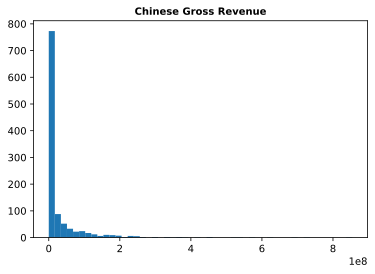

In [61]:
print(f"Median vs Mean: {combined['PRC_rev'].median()}, {combined['PRC_rev'].mean():.1f}")
plt.hist(combined['PRC_rev'], bins=50)
plt.title("Chinese Gross Revenue", fontsize=10, weight='bold')
;

Please proceed to the Modeling and Analysis notebook.